In [1]:
!curl -o test_set.zip https://zenodo.org/records/1327317/files/test_set.zip?download=1 -o test_set_pixel_size.csv https://zenodo.org/records/1327317/files/test_set_pixel_size.csv?download=1 -o training_set.zip https://zenodo.org/records/1327317/files/training_set.zip?download=1 -o training_set_pixel_size_and_HC.csv https://zenodo.org/records/1327317/files/training_set_pixel_size_and_HC.csv?download=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41.5M  100 41.5M    0     0  11.2M      0  0:00:03  0:00:03 --:--:-- 11.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9096  100  9096    0     0  29677      0 --:--:-- --:--:-- --:--:-- 29628
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  126M  100  126M    0     0  20.1M      0  0:00:06  0:00:06 --:--:-- 20.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33688  100 33688    0     0   112k      0 --:--:-- --:--:-- --:--:--  113k


In [2]:
# importing the zipfile module 
from zipfile import ZipFile 

# loading the temp.zip and creating a zip object 
with ZipFile("/kaggle/working/training_set.zip", 'r') as zObject:  
    zObject.extractall( 
        path="/kaggle/working/") 
with ZipFile("/kaggle/working/test_set.zip", 'r') as zObject:  
    zObject.extractall( 
        path="/kaggle/working/") 


In [1]:
import matplotlib.pyplot as plt


In [2]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os
import torch
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

class UltrasoundDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        # Input image of model: all images in img_dir not containing "Annotation" in name
        # Output image of model: all images in img_dir containing "Annotation" in name
        self.img_dir = img_dir
        self.transform = transform
        self.imgs = sorted([x for x in os.listdir(img_dir) if "Annotation" not in x])
        self.masks = sorted([x for x in os.listdir(img_dir) if "Annotation" in x])

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        mask_path = os.path.join(self.img_dir, self.masks[idx])
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

In [3]:
# Define the transformation (3 channels to 1 channel)
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor()])
# Create the dataset
train_dataset = UltrasoundDataset(img_dir="training_set", transform=transform)
# 80% of the data will be used for training, 10% for validation, and 10% for testing
# Create the indices
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)
split = int(np.floor(0.1 * dataset_size))
train_indices, val_indices, test_indices = indices[split*2:], indices[:split], indices[split:split*2]
# Create the samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)
# Create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, sampler=test_sampler)

In [4]:
import torch
import torch.nn as nn
# import torchsummary
from scipy.ndimage import gaussian_filter


def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512) 
        self.dconv_down5 = double_conv(512, 1024)
        self.dconv_down6 = double_conv(1024, 2048)       
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up5 = double_conv(1024 + 2048, 1024)
        self.dconv_up4 = double_conv(512 + 1024, 512)
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        conv5 = self.dconv_down5(x)
        x = self.maxpool(conv5)

        x = self.dconv_down6(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv5], dim=1)

        x = self.dconv_up5(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv4], dim=1)

        x = self.dconv_up4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out
    
# # Summary of the model
# model = UNet(n_class=1)
# torchsummary.summary(model, (1, 256, 256))

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=1).to(device)
# Loss function: Binary Cross Entropy
criterion = nn.BCEWithLogitsLoss()
# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
from tqdm import tqdm
def train(model, train_loader, valid_loader, criterion, optimizer, n_epochs=10):
    loss_train = []
    loss_valid = []
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        
        loss_train.append(running_loss/len(train_loader))
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {running_loss/len(train_loader)}")
        torch.save(model.state_dict(), 'last.pth')
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                # Plot the training and validation loss

            loss_valid.append(running_loss/len(valid_loader))
            print(f"Validation Loss: {running_loss/len(valid_loader)}")
    return loss_train, loss_valid

In [9]:
loss_train, loss_valid = train(model, train_loader, val_loader, criterion, optimizer, n_epochs=20)

100%|██████████| 200/200 [00:42<00:00,  4.65it/s]


Epoch 1/20 - Loss: 1.485060181207955
Validation Loss: 0.03879313513636589


100%|██████████| 200/200 [00:42<00:00,  4.70it/s]


Epoch 2/20 - Loss: 0.0364654908888042
Validation Loss: 0.036077575981616976


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 3/20 - Loss: 0.034935794854536656
Validation Loss: 0.0328682079911232


100%|██████████| 200/200 [00:42<00:00,  4.69it/s]


Epoch 4/20 - Loss: 0.029981819903478025
Validation Loss: 0.029828618317842483


100%|██████████| 200/200 [00:42<00:00,  4.69it/s]


Epoch 5/20 - Loss: 0.02699359592050314
Validation Loss: 0.026395796462893487


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 6/20 - Loss: 0.026119107939302923
Validation Loss: 0.02661505527794361


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 7/20 - Loss: 0.025471145203337073
Validation Loss: 0.02690401129424572


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 8/20 - Loss: 0.02510472250171006
Validation Loss: 0.0258919445425272


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 9/20 - Loss: 0.024572811415418984
Validation Loss: 0.02606031723320484


100%|██████████| 200/200 [00:42<00:00,  4.69it/s]


Epoch 10/20 - Loss: 0.02428695097565651
Validation Loss: 0.025060061290860178


100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 11/20 - Loss: 0.02409196276217699
Validation Loss: 0.025173941031098365


100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 12/20 - Loss: 0.023696873029693963
Validation Loss: 0.02504860147833824


100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 13/20 - Loss: 0.023388142054900526
Validation Loss: 0.02584708921611309


100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 14/20 - Loss: 0.023074394315481184
Validation Loss: 0.02500216268002987


100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 15/20 - Loss: 0.022632405972108246
Validation Loss: 0.025242197811603546


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 16/20 - Loss: 0.022583782067522408
Validation Loss: 0.02501274138689041


100%|██████████| 200/200 [00:42<00:00,  4.69it/s]


Epoch 17/20 - Loss: 0.022193632051348687
Validation Loss: 0.025655326992273332


100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 18/20 - Loss: 0.021852225819602607
Validation Loss: 0.02630078375339508


100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 19/20 - Loss: 0.02155559609644115
Validation Loss: 0.025730992630124093


100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 20/20 - Loss: 0.021253791898489
Validation Loss: 0.02637545995414257


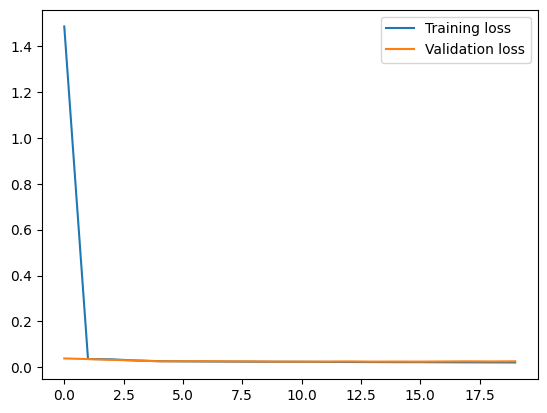

In [10]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(loss_train, label='Training loss')
plt.plot(loss_valid, label='Validation loss')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'model_bce.pth')


In [8]:
# Make predictions on the test set and use MAE as evaluation metric
from sklearn.metrics import mean_absolute_error

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
print(f"Mean Absolute Error: {mae}")
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou = iou_score(y_true, y_pred)
print(f"IoU: {iou}")


Mean Absolute Error: 38.6395378112793
IoU: 0.022667316475299872


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=1).to(device)
model.load_state_dict(torch.load("model_bce.pth", map_location = device))

<All keys matched successfully>

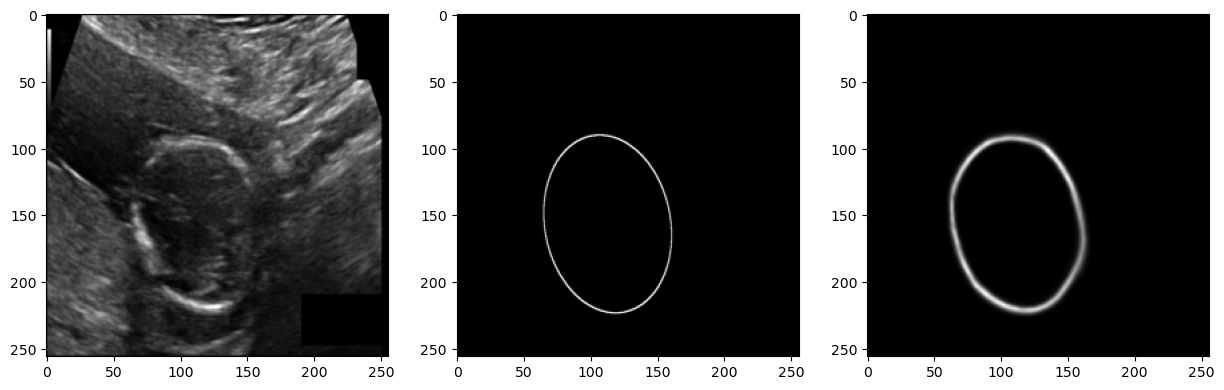

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


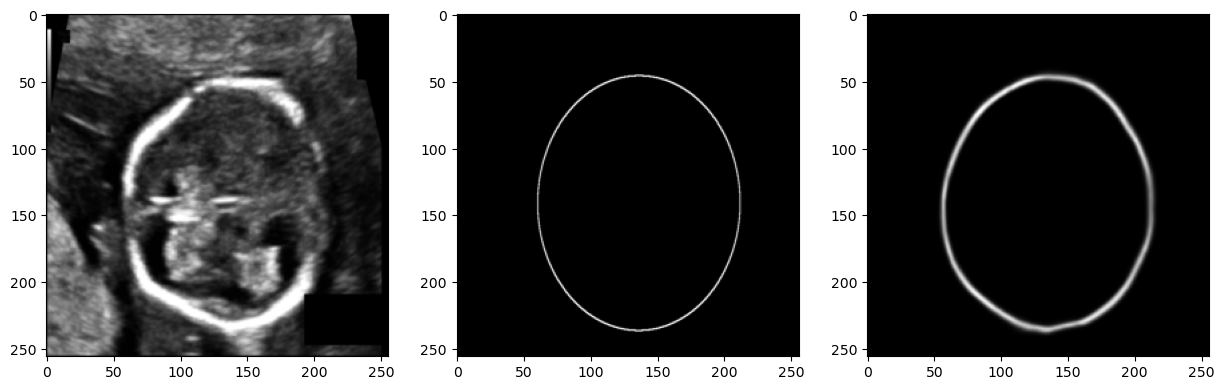

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


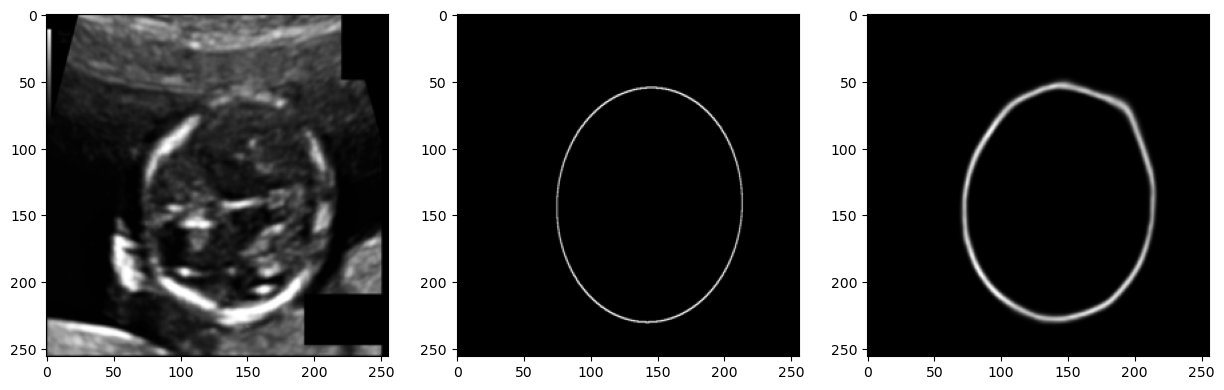

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


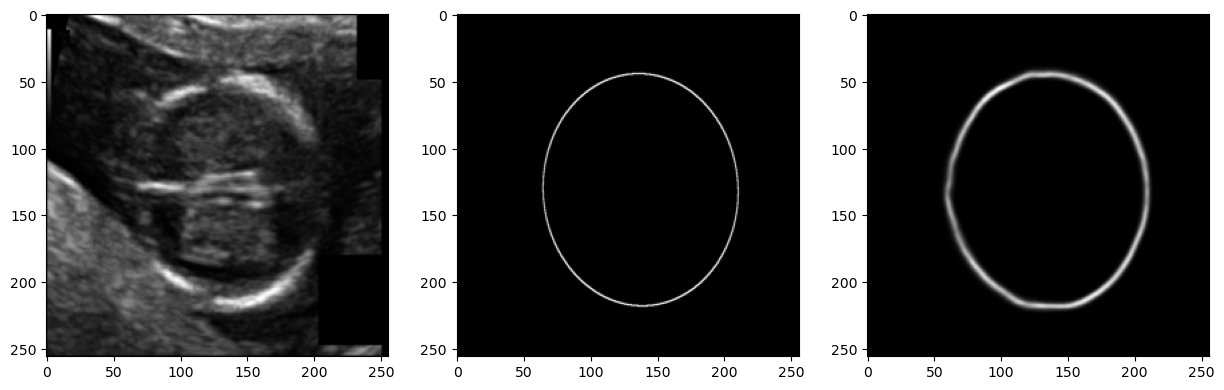

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


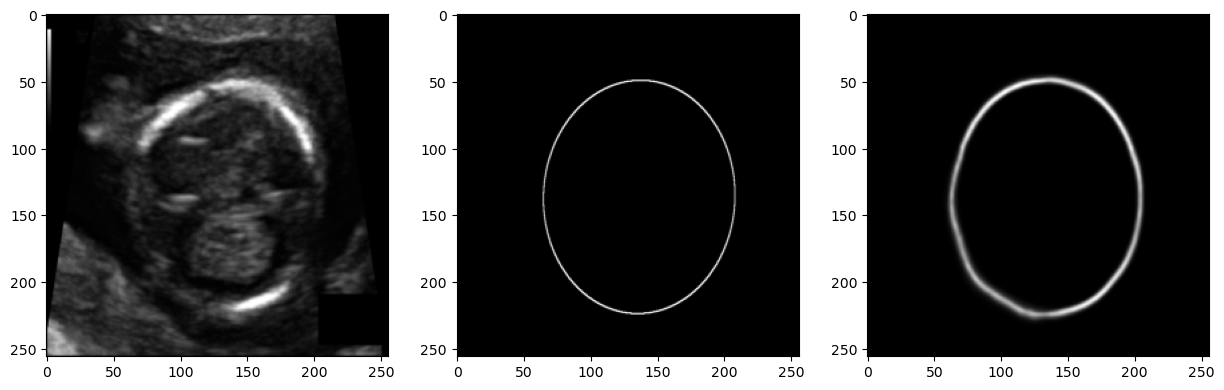

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [19]:
import matplotlib.pyplot as plt

image_idx = 10
for image_idx in range(150, 155):
    image = train_dataset[image_idx][0]
    image_infer = train_dataset[image_idx][1]
    output = model(image.unsqueeze(0))
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and a set of subplots

    axs[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ultrasound Image")
    axs[1].imshow(np.transpose(image_infer.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ground Truth Mask")
    axs[2].imshow(np.transpose(torch.sigmoid(output.squeeze(0)).cpu().detach().numpy(), (1, 2, 0)), cmap = "gray", label = "Predicted Mask")

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


In [24]:
class IoULoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(IoULoss, self).__init__()
        self.eps = eps

    def forward(self, inputs, targets):
        # Compute intersection
        intersection = (inputs * targets).sum()
        # Compute union
        total = (inputs + targets).sum()
        union = total - intersection 

        iou = (intersection + self.eps) / (union + self.eps)
        return 1 - iou
    
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.8):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.iou = IoULoss()

    def forward(self, inputs, targets):
        return self.alpha * self.bce(inputs, targets) + (1 - self.alpha) * self.iou(inputs, targets)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_combine = UNet(n_class=1).to(device)
# Now use IoU as the loss function
criterion = CombinedLoss()
# Optimizer: Adam
optimizer = torch.optim.Adam(model_combine.parameters(), lr=0.001)
loss_train, loss_valid = train(model_combine, train_loader, val_loader, criterion, optimizer, n_epochs=20)

100%|██████████| 201/201 [00:42<00:00,  4.71it/s]


Epoch 1/20 - Loss: 0.4388685857330389
Validation Loss: 0.22888220071792603


100%|██████████| 201/201 [00:42<00:00,  4.71it/s]


Epoch 2/20 - Loss: 0.2277105266775065
Validation Loss: 0.2265581178665161


100%|██████████| 201/201 [00:42<00:00,  4.70it/s]


Epoch 3/20 - Loss: 0.2246225136726057
Validation Loss: 0.22325503051280976


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 4/20 - Loss: 0.22173961478086254
Validation Loss: 0.221441895365715


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 5/20 - Loss: 0.22085662193559297
Validation Loss: 0.22087298035621644


100%|██████████| 201/201 [00:42<00:00,  4.70it/s]


Epoch 6/20 - Loss: 0.22018670138731525
Validation Loss: 0.22037001252174376


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 7/20 - Loss: 0.22000270511083936
Validation Loss: 0.22021422505378724


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 8/20 - Loss: 0.2195424280356412
Validation Loss: 0.22018968880176545


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 9/20 - Loss: 0.21927460605528817
Validation Loss: 0.21966280341148375


100%|██████████| 201/201 [00:42<00:00,  4.70it/s]


Epoch 10/20 - Loss: 0.21888537890282436
Validation Loss: 0.2199418479204178


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 11/20 - Loss: 0.21863353949281114
Validation Loss: 0.21964903473854064


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 12/20 - Loss: 0.21829945367960193
Validation Loss: 0.22004112005233764


100%|██████████| 201/201 [00:42<00:00,  4.70it/s]


Epoch 13/20 - Loss: 0.21806409777100408
Validation Loss: 0.21970212757587432


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 14/20 - Loss: 0.2178391125516512
Validation Loss: 0.21972445130348206


100%|██████████| 201/201 [00:42<00:00,  4.70it/s]


Epoch 15/20 - Loss: 0.21748529048404883
Validation Loss: 0.22039551198482513


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 16/20 - Loss: 0.2172600085017693
Validation Loss: 0.21997737646102905


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 17/20 - Loss: 0.21717908363140637
Validation Loss: 0.21950015246868135


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 18/20 - Loss: 0.21669063602217395
Validation Loss: 0.22125054717063905


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 19/20 - Loss: 0.21655163235628783
Validation Loss: 0.22074321985244752


100%|██████████| 201/201 [00:42<00:00,  4.69it/s]


Epoch 20/20 - Loss: 0.21618927770586155
Validation Loss: 0.2211002629995346


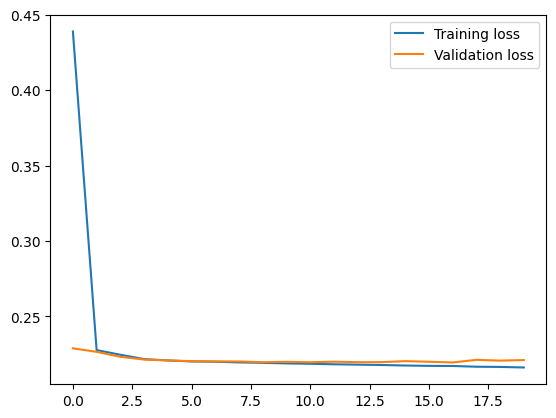

In [33]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(loss_train, label='Training loss')
plt.plot(loss_valid, label='Validation loss')
plt.legend()
plt.show()

# Save the model
torch.save(model_combine.state_dict(), 'model_bce_iou_1.pth')


In [21]:
# Make predictions on the test set and use MAE as evaluation metric
from sklearn.metrics import mean_absolute_error

model_combine.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_combine(inputs)
        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
print(f"Mean Absolute Error: {mae}")
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou = iou_score(y_true, y_pred)
print(f"IoU: {iou}")


Mean Absolute Error: 11.89914321899414
IoU: 0.022667316475299872


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_combine = UNet(n_class=1).to(device)
model_combine.load_state_dict(torch.load("model_bce_iou_1.pth", map_location = device))

<All keys matched successfully>

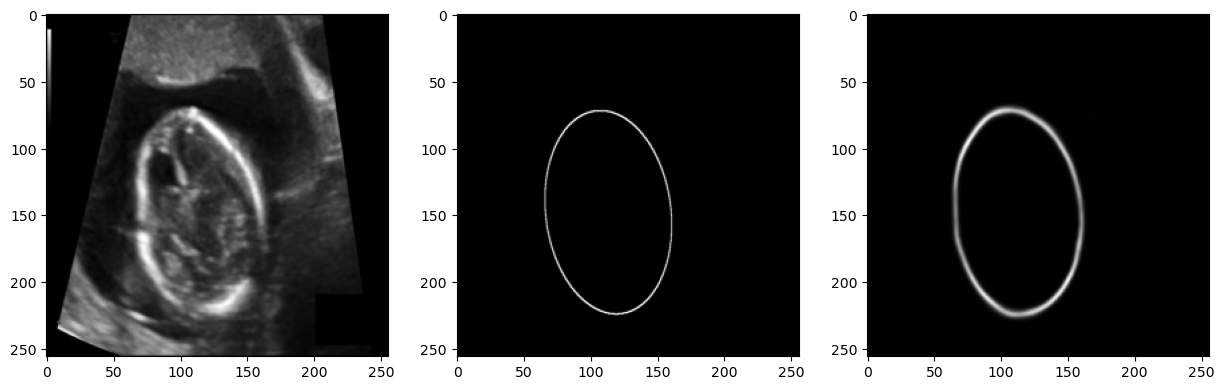

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


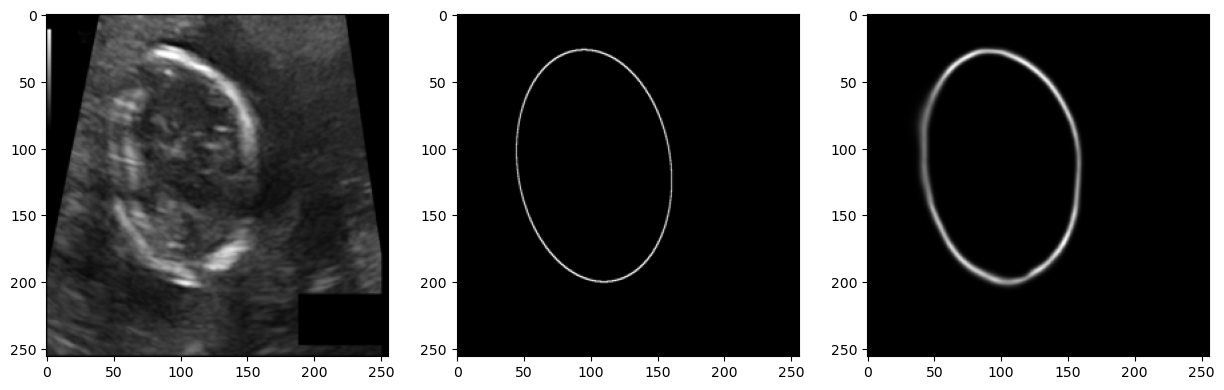

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


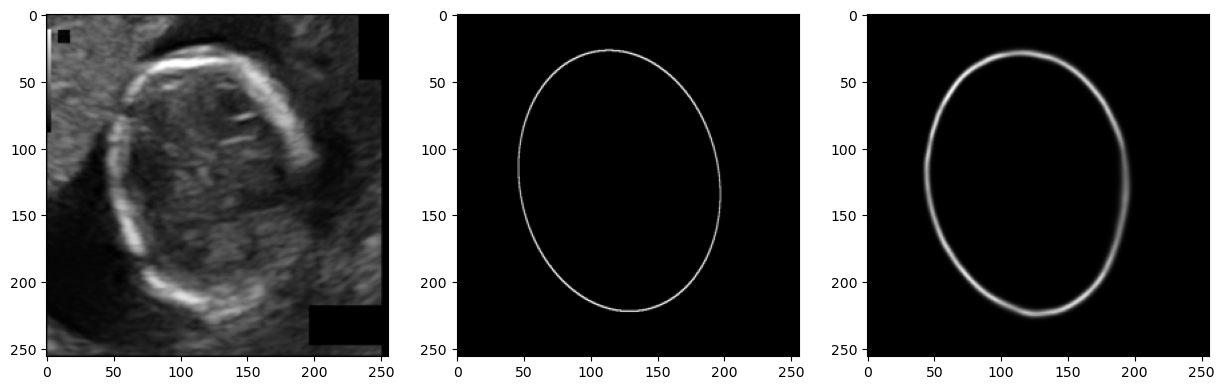

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


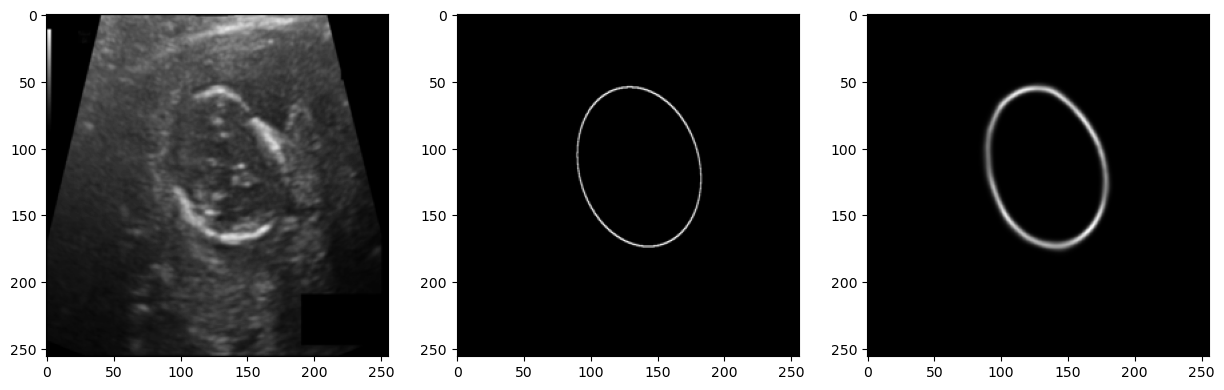

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


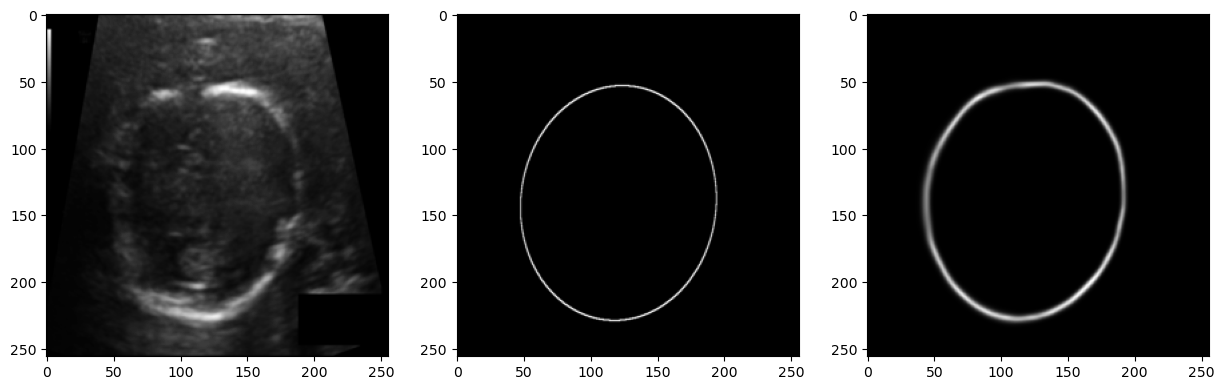

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


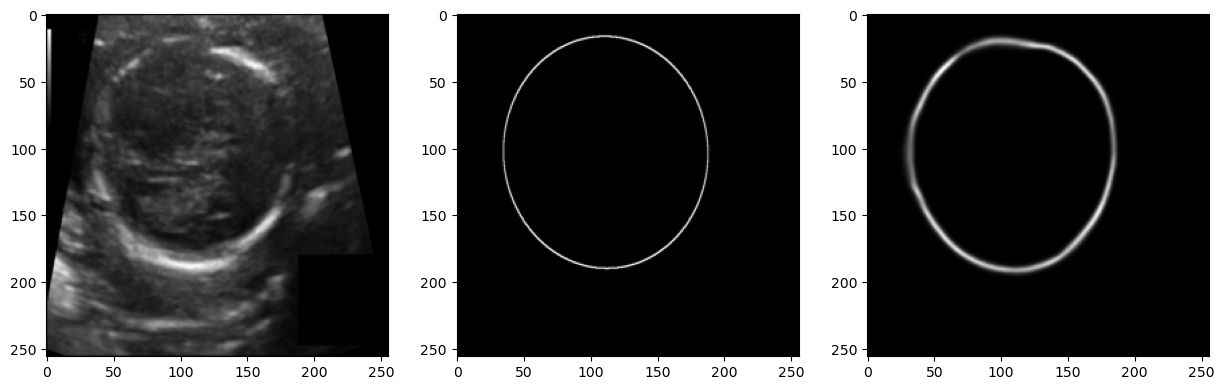

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


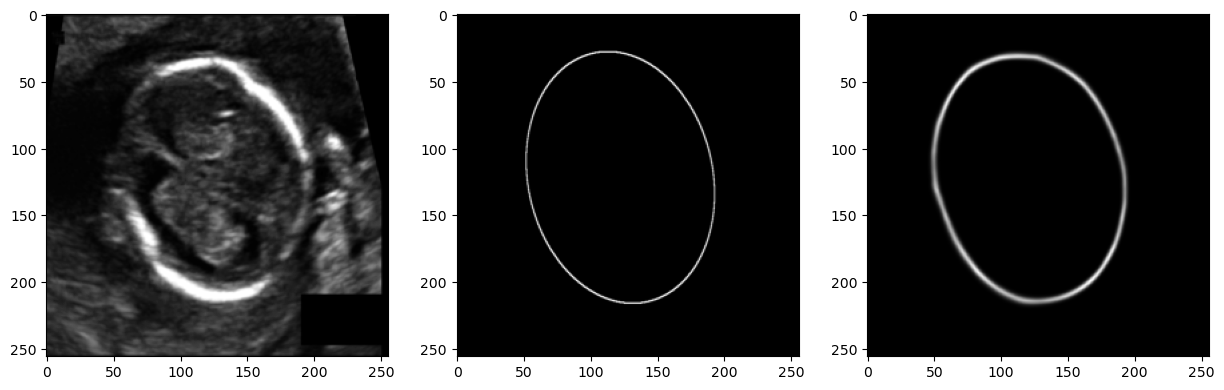

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


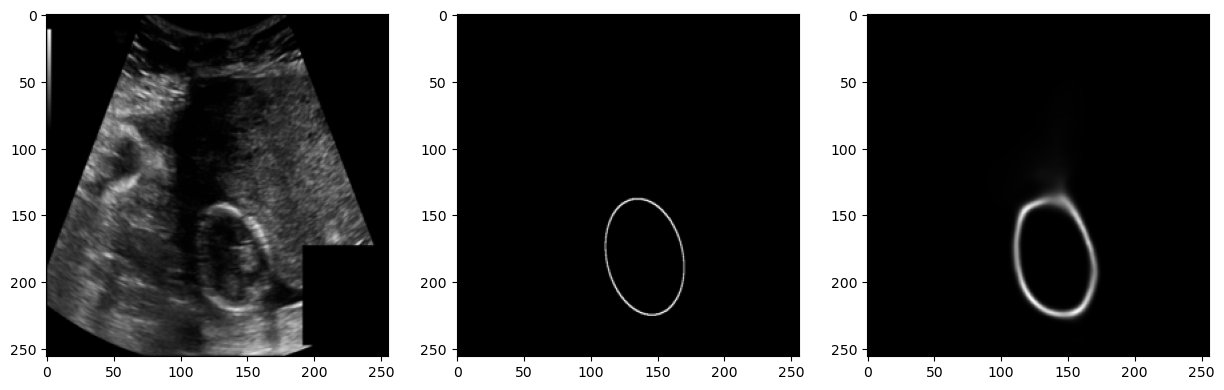

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


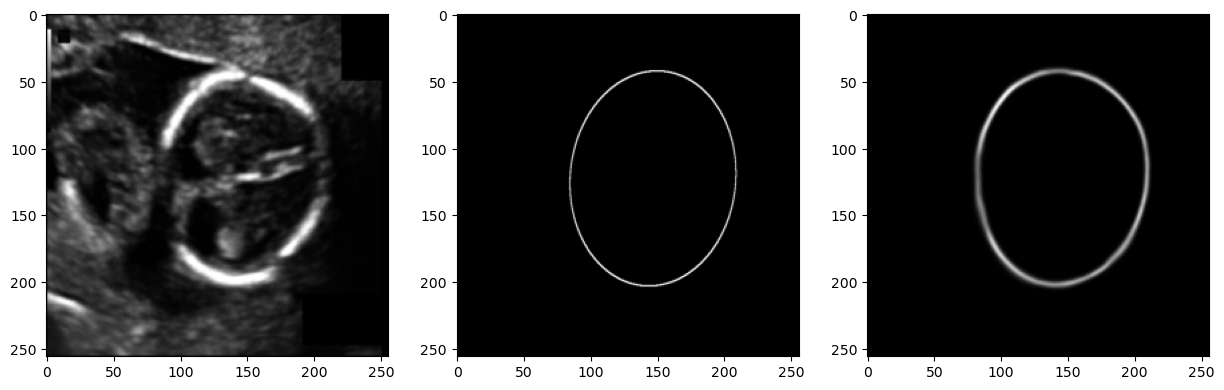

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


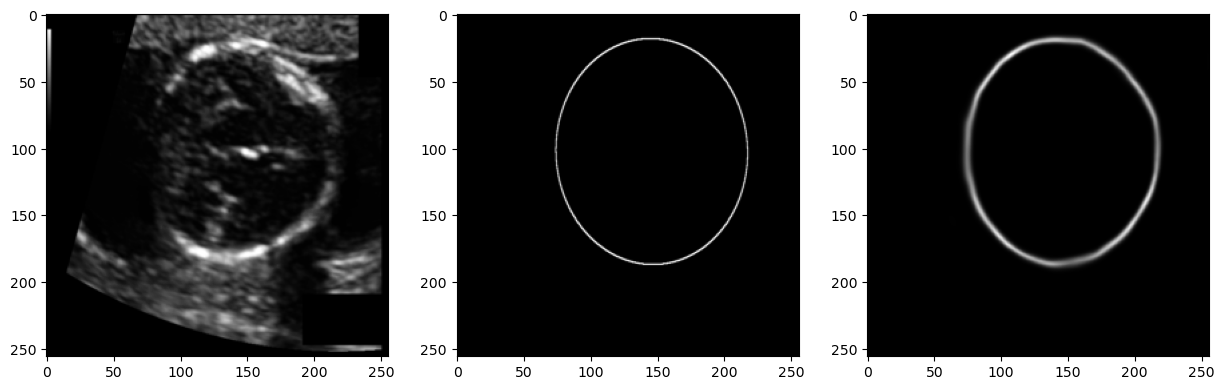

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [33]:
for image_idx in range(170, 180):
    image = train_dataset[image_idx][0]
    image_infer = train_dataset[image_idx][1]
    output = model_combine(image.unsqueeze(0))
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and a set of subplots

    axs[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ultrasound Image")
    axs[1].imshow(np.transpose(image_infer.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ground Truth Mask")
    axs[2].imshow(np.transpose(torch.sigmoid(output.squeeze(0)).cpu().detach().numpy(), (1, 2, 0)), cmap = "gray", label = "Predicted Mask")

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mse = UNet(n_class=1).to(device)
# Now use IoU as the loss function
criterion = nn.MSELoss()
# Optimizer: Adam
optimizer = torch.optim.Adam(model_mse.parameters(), lr=0.001)
loss_train, loss_valid = train(model_mse, train_loader, val_loader, criterion, optimizer, n_epochs=20)

In [ ]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(loss_train, label='Training loss')
plt.plot(loss_valid, label='Validation loss')
plt.legend()
plt.show()

# Save the model
torch.save(model_mse.state_dict(), 'model_mse.pth')


In [26]:
# Make predictions on the test set and use MAE as evaluation metric
from sklearn.metrics import mean_absolute_error

model_mse.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_mse(inputs)
        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
print(f"Mean Absolute Error: {mae}")
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou = iou_score(y_true, y_pred)
print(f"IoU: {iou}")

Mean Absolute Error: 0.010813026688992977
IoU: 0.022667316475299872


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mse = UNet(n_class=1).to(device)
model_mse.load_state_dict(torch.load("model_mse.pth", map_location = device))

<All keys matched successfully>

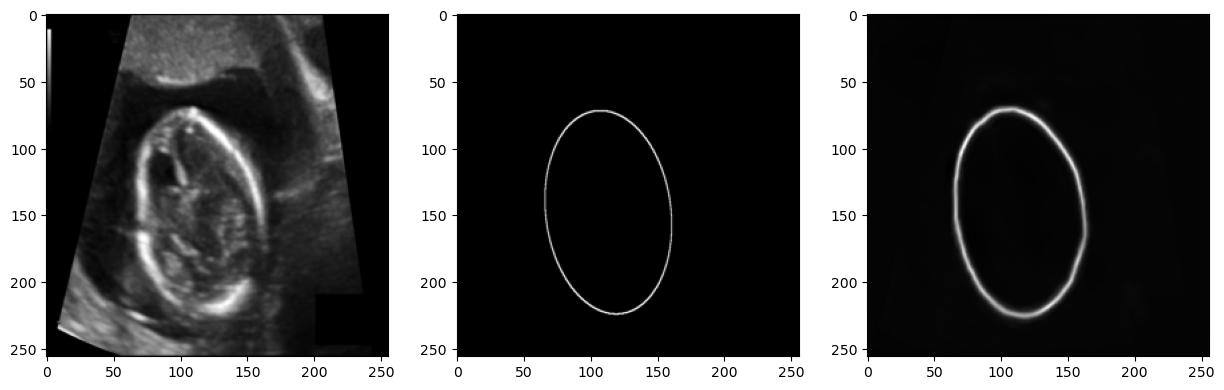

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


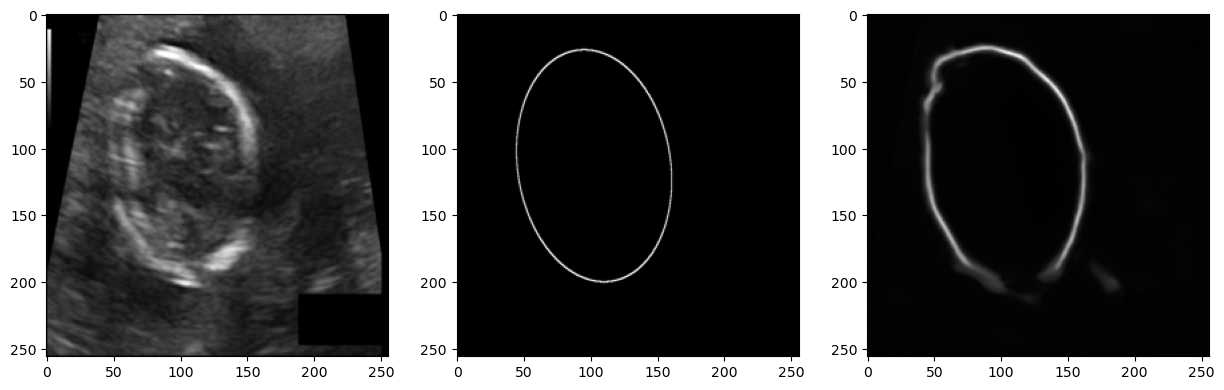

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


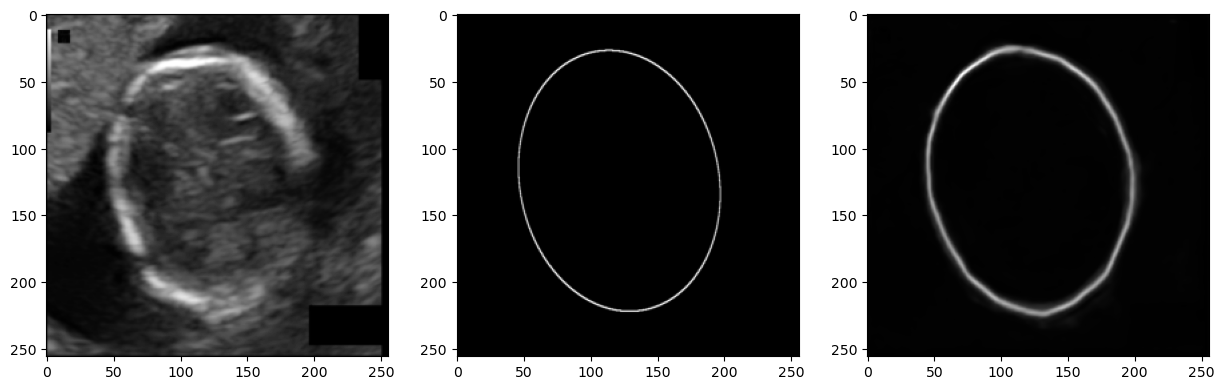

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


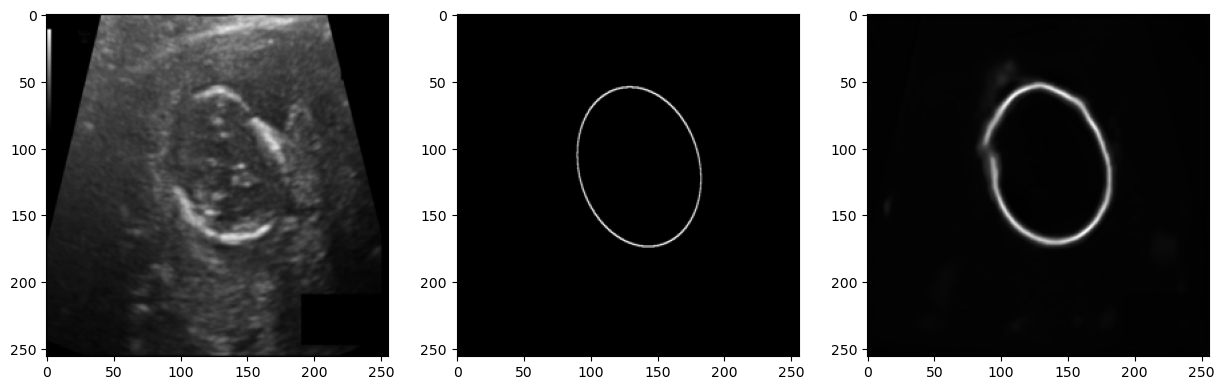

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


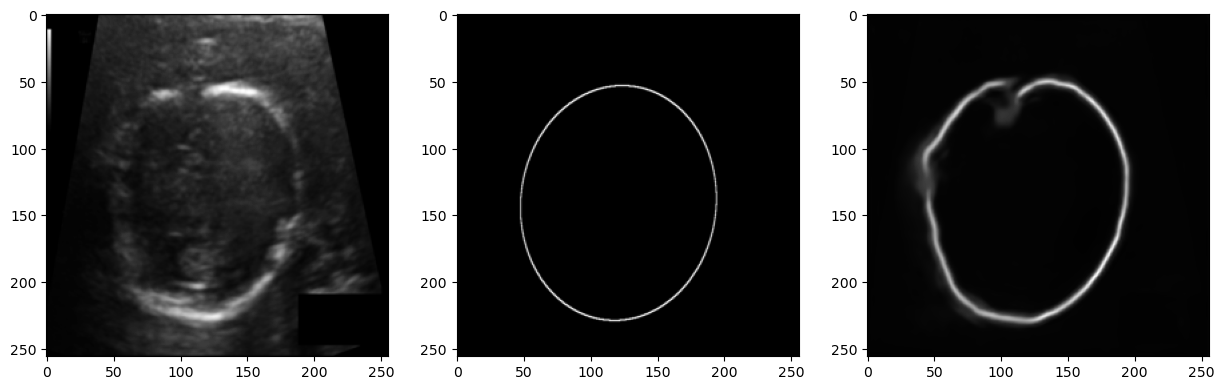

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


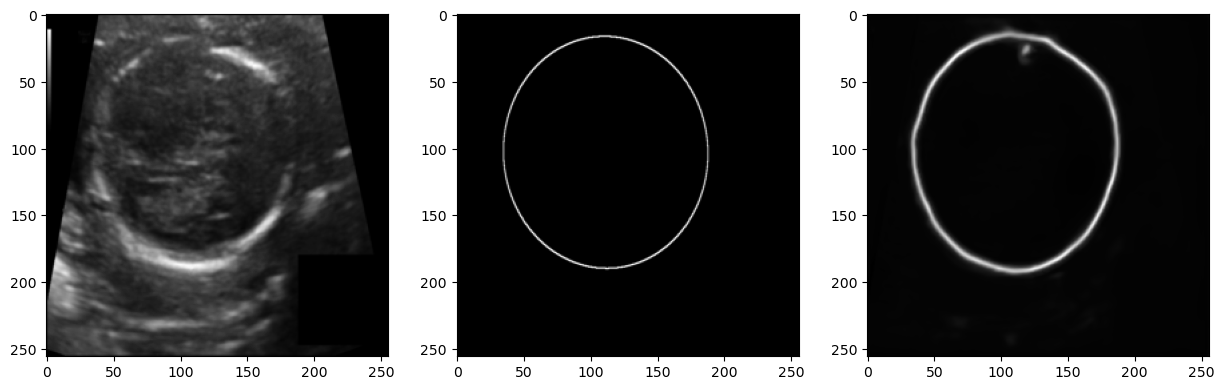

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


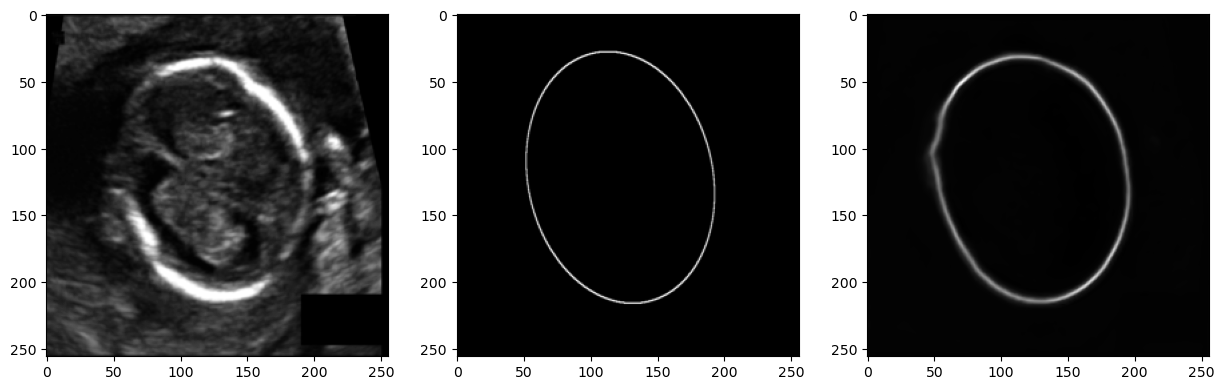

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


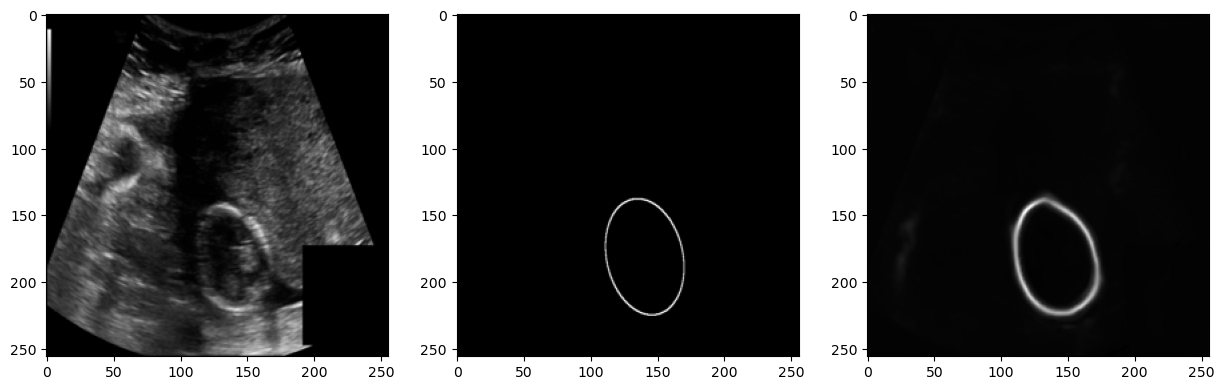

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


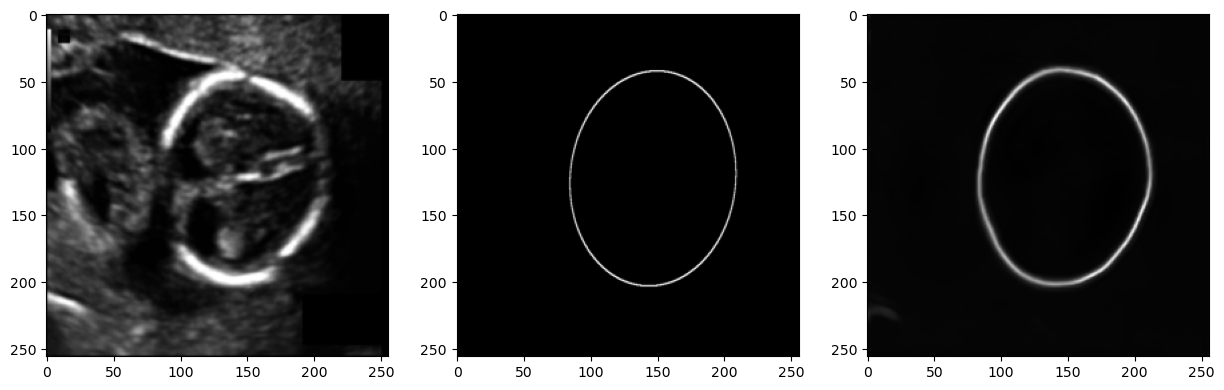

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


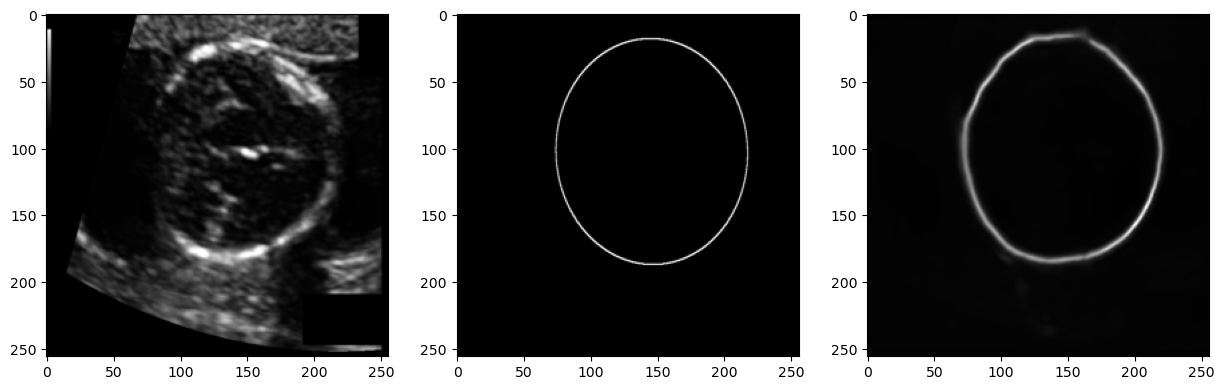

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [32]:
for image_idx in range(170, 180):
    image = train_dataset[image_idx][0]
    image_infer = train_dataset[image_idx][1]
    output = model_mse(image.unsqueeze(0))
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and a set of subplots

    axs[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ultrasound Image")
    axs[1].imshow(np.transpose(image_infer.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ground Truth Mask")
    axs[2].imshow(np.transpose(torch.sigmoid(output.squeeze(0)).cpu().detach().numpy(), (1, 2, 0)), cmap = "gray", label = "Predicted Mask")

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


In [42]:
# Infer the test set with no ground truth
class UltrasoundTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.imgs = sorted([x for x in os.listdir(img_dir)])

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image
    
# Create the dataset 
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor()])
test_dataset = UltrasoundTestDataset(img_dir="test_set", transform=transform)

# Create the dataloader
tester_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

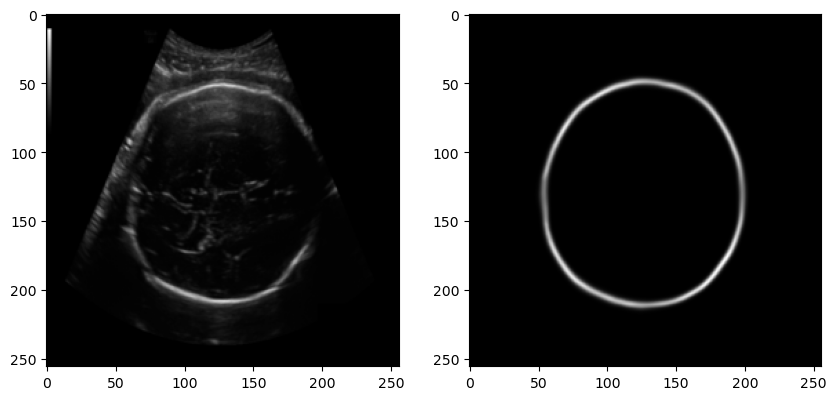

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


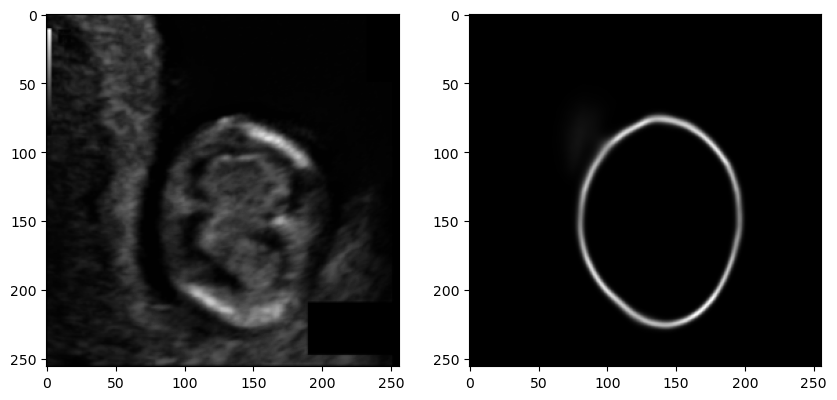

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


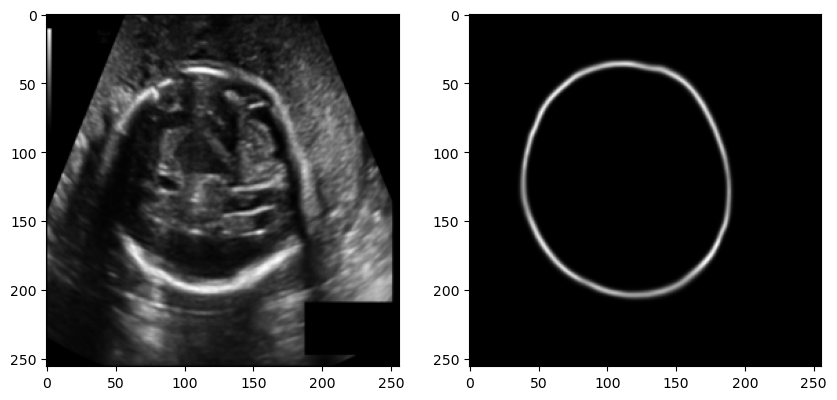

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


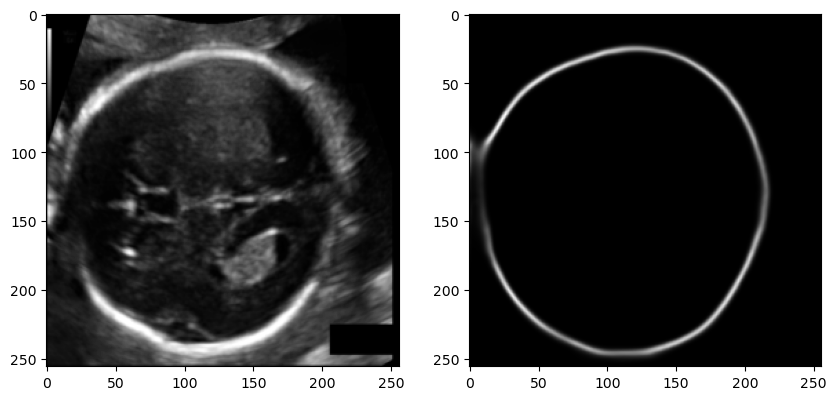

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


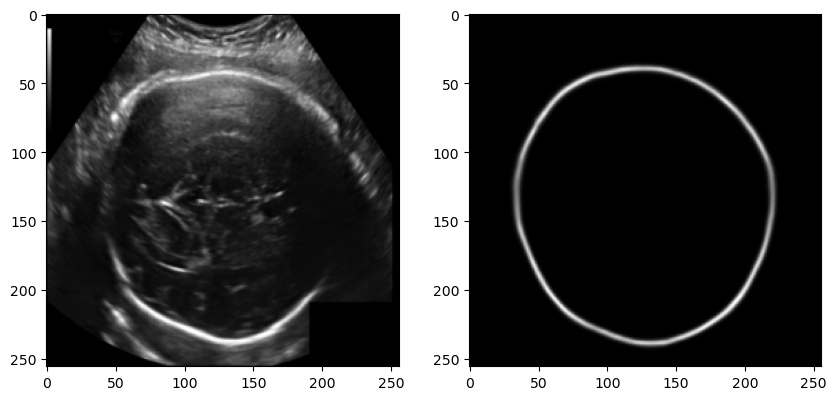

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [50]:
# Inference by plotting the first 5 images with combined loss model
model_combine.eval()
for image_idx in range(5):
    image = test_dataset[image_idx]
    output = model_combine(image.unsqueeze(0))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure and a set of subplots

    axs[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ultrasound Image")
    axs[1].imshow(np.transpose(torch.sigmoid(output.squeeze(0)).cpu().detach().numpy(), (1, 2, 0)), cmap = "gray", label = "Predicted Mask")

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

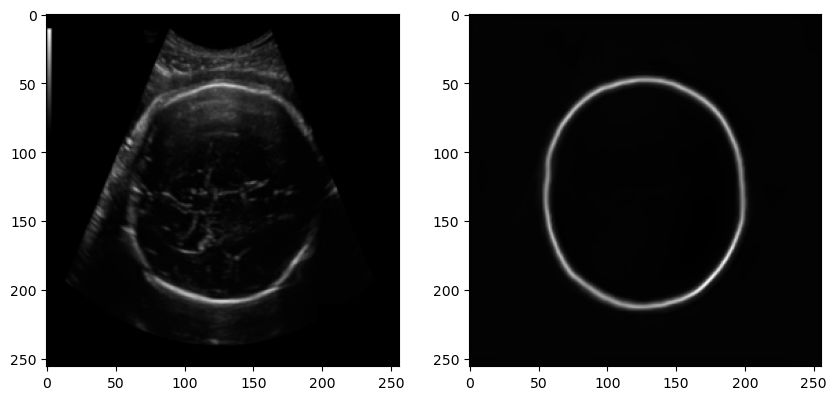

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


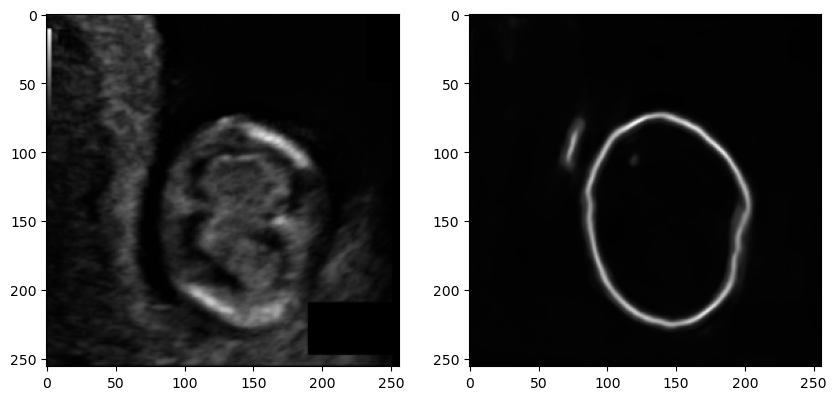

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


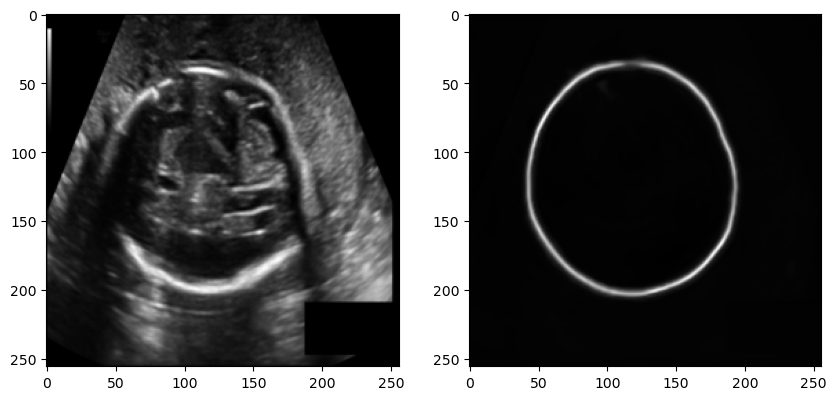

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


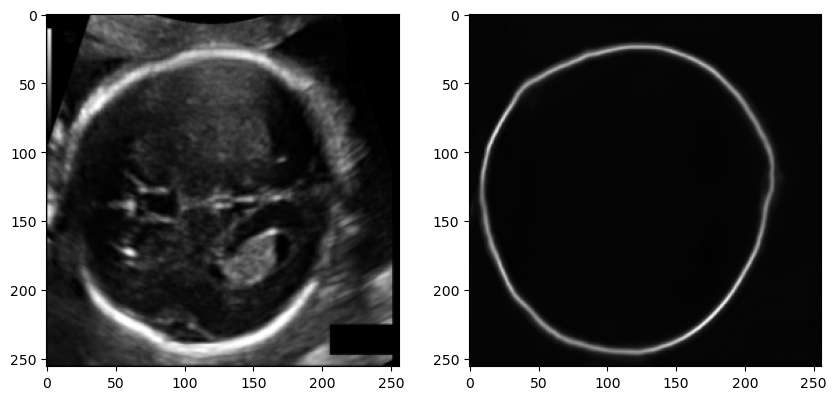

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


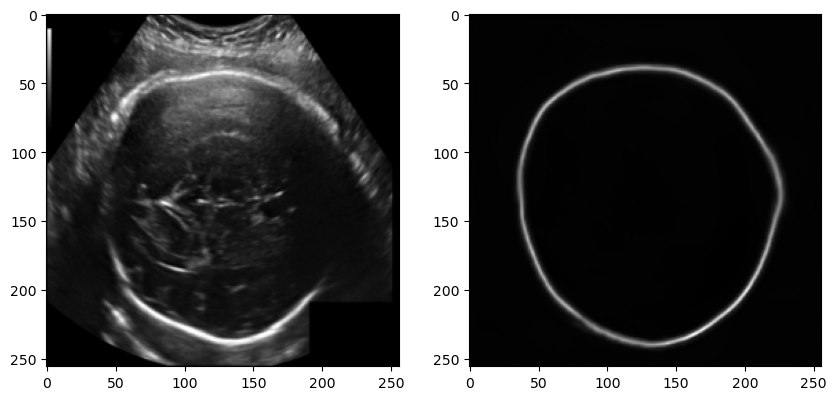

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [44]:
# Inference by plotting the first 5 images with combined loss model
model_mse.eval()
for image_idx in range(5):
    image = test_dataset[image_idx]
    output = model_mse(image.unsqueeze(0))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure and a set of subplots

    axs[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ultrasound Image")
    axs[1].imshow(np.transpose(torch.sigmoid(output.squeeze(0)).cpu().detach().numpy(), (1, 2, 0)), cmap = "gray", label = "Predicted Mask")

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")